# Comparison of MLP vs Transformer-Only Models

Comparison of models, using a dataset of python code. The aim is to find
interesting prompts where an MLP layer is required to accurately predict next tokens.


## Imports

In [1]:
from easy_transformer import EasyTransformer
import torch
from IPython.core.display import display
from ipywidgets import widgets
from typing import List
import pandas as pd
import numpy as np
from torchtyping import TensorType
from torch.nn import functional as F
from einops import rearrange
import plotly.express as px
import matplotlib.pyplot as plt
from datasets import load_dataset
from tqdm import tqdm
from circuitsvis.tokens import colored_tokens
from codegen import infer

/tmp/ipykernel_28701/1771121644.py:3: DeprecationWarning: Importing clear_output from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import clear_output


## Run the models on the code dataset

Run all models (or load from checkpoints if they already exist).

In [2]:
models = [
        "NeelNanda/SoLU_1L512W_C4_Code",
        # "NeelNanda/SoLU_2L512W_C4_Code",
        # "NeelNanda/SoLU_3L512W_C4_Code",
        # "NeelNanda/SoLU_4L512W_C4_Code",
        # "NeelNanda/SoLU_6L768W_C4_Code",
        # "NeelNanda/SoLU_8L1024W_C4_Code",
        # "NeelNanda/SoLU_10L1280W_C4_Code",
        # "NeelNanda/SoLU_12L1536W_C4_Code",
        # "NeelNanda/GELU_1L512W_C4_Code",
        # "NeelNanda/GELU_2L512W_C4_Code",
        # "NeelNanda/GELU_3L512W_C4_Code",
        # "NeelNanda/GELU_4L512W_C4_Code",
        "NeelNanda/Attn_Only_1L512W_C4_Code",
        # "NeelNanda/Attn_Only_2L512W_C4_Code",
        # "NeelNanda/Attn_Only_3L512W_C4_Code",
        # "NeelNanda/Attn_Only_4L512W_C4_Code",
        # "gpt2",
        # "gpt2-medium"
    ]

results = {}
for model_name in models:
    results[model_name] = infer.run_model(model_name)

results.keys(), list(results.values())[0].shape

Loading model: NeelNanda/Attn_Only_1L512W_C4_Code
Moving model to device:  cuda
Finished loading pretrained model NeelNanda/Attn_Only_1L512W_C4_Code into EasyTransformer!


Using custom data configuration NeelNanda--code-tokenized-d313277bd840bb66
Found cached dataset parquet (/home/user/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--code-tokenized-d313277bd840bb66/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


Running NeelNanda/Attn_Only_1L512W_C4_Code


 34%|███▎      | 9999/29726 [11:25<22:22, 14.69it/s]

### Get the prompts for this dataset

In [ ]:
prompts_dataset = load_dataset("NeelNanda/code-tokenized", split="train")

prompts_tokens: List[List[int]] = []
for prompt_tokens in tqdm(prompts_dataset):
    prompts_tokens.append(prompt_tokens["tokens"])

# Get the prompts tokens
prompts_tokens = np.array(prompts_tokens)

prompts_tokens.shape

## Model comparison aggregate results

In [ ]:
# Get the difference in performance between models
prob_diff = np.exp(results["NeelNanda/SoLU_1L512W_C4_Code"]) \
    - np.exp(results["NeelNanda/Attn_Only_1L512W_C4_Code"])

prob_diff.shape

(297000, 1023)

### Histogram of differences by token

In [ ]:
prob_diff_flat: np.ndarray = prob_diff.flatten()
plt.hist(prob_diff_flat, bins=100)

### Histogram of differences by prompt

In [ ]:
prob_diff_by_prompt = np.mean(prob_diff, axis=-1)
plt.hist(prob_diff_by_prompt, bins=100)

## Prompts that are most impacted by adding MLP layers

In [ ]:
# Rank the prompts by number of tokens that are significantly better with the
# MLP layer
threshold = 0.1
count_prob_diff_above_threshold = np.sum(prob_diff > threshold, axis=-1)
ranked_prompts = pd.DataFrame({"count_significant": count_prob_diff_above_threshold})
ranked_prompts.sort_values(by="count_significant", ascending=False, inplace=True)
prompt_ids_ranked = ranked_prompts.index.values

# Show histogram for the number of tokens that are significantly better, per prompt
ranked_prompts.hist(bins=100)

### Dropdown to view prob diff by token, for different prompts

In [ ]:
def show_prob_diff_colored_tokens(prompt_id: int) -> None:
    prompt_token_diff = prob_diff[prompt_id, :]
    
    tokenizer = EasyTransformer.from_pretrained("NeelNanda/SoLU_1L512W_C4_Code").tokenizer
    token_strings = [tokenizer.decode(t) for t in prompt_tokens[prompt_id]][0:-1]
    
    return colored_tokens(
        values=prompt_token_diff,
        tokens=token_strings,
        min_value=0,
        max_value=1,
        max_color="green",
    )
    
w = widgets.Dropdown(
    options=prompt_ids_ranked,
    value='Prompt ID',
)

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        display(show_prob_diff_colored_tokens(change['new']))

w.observe(on_change)

display(w)

### Prompt

### Try a specific prompt with all models

In [ ]:
prompt_tokens = prompts_tokens[255803][1:] # Remove the first token as it's added in again
prompt = model.tokenizer.decode(prompt_tokens)
type(prompt)

str

In [ ]:
model_results = {}

for model_idx, model_name in enumerate(models):
    # Free up CUDA memory (from previous model)
    torch.cuda.empty_cache()
    
    # Load up the model
    model = EasyTransformer.from_pretrained(model_name)
    
    # Get the predictions
    logits: TensorType["batch", "position", "vocab"] = model(prompt)
    logits_single_batch: TensorType["position", "vocab"] = logits[0]
    logits_except_last: TensorType["position", "vocab"] = logits_single_batch[1:-1, :] # We also remove the first (start of sequence token)
    # predictions: TensorType["batch", "position", "vocab"] = torch.argmax(logits, 2)
    
    # Get the probabilities
    probabilities: TensorType["position", "vocab"] = F.softmax(logits_except_last, dim=1)
    probabilities_np = probabilities.detach().cpu().numpy()
    
    # Get the probabilities of the correct tokens
    correct_tokens = model.tokenizer.encode(prompt)[1:]
    correct_tokens_np = np.array(correct_tokens)
    
    print(correct_tokens_np.shape, probabilities_np.shape) # (856,) torch.Size([856, 48262])
    probabilities_correct = probabilities_np[np.arange(len(probabilities_np)),correct_tokens_np]
    
    
    
    # predictions_except_last = predictions.cpu().squeeze().numpy()[1:-1]
    # accurate = np.equal(np.array(correct_tokens),(predictions_except_last))
    
    # Store
    model_results[model_name] = probabilities_correct

    
clear_output()     

# Create the results DataFrame
results = pd.DataFrame(model_results)

# Set the token labels
tokens = model.tokenizer.encode(prompt)
token_labels = [model.tokenizer.decode(token) for token in tokens[0:-1]]
results.insert(0, "Token", token_labels)

In [ ]:
# Show the average probability of the correct tokens by model
results_by_model = pd.DataFrame(model_results)
average_results_by_model = results_by_model.mean()
average_results_by_model.apply(lambda x: "{:.2%}".format(x))

NeelNanda/SoLU_1L512W_C4_Code         39.09%
NeelNanda/Attn_Only_1L512W_C4_Code    34.15%
dtype: object

### Results

In [ ]:
def compare_model_correct_token_probability(modelA: str, modelB: str) -> pd.DataFrame:
    """Compare the correct token probabilities of two models

    Args:
        modelA (str): Model name (of model that is expected to be better)
        modelB (str): Model name (of model that is expected to be worse)

    Returns:
        pd.DataFrame: DataFrame with the relative accuracy of each model
    """
    relevant_results = results[["Token",modelA, modelB]]
    diff = relevant_results[modelA] - relevant_results[modelB]
    relevant_results.insert(3, "Difference", diff)
    # relevant_results = relevant_results.sort_values(by="Difference", ascending=False)
    return relevant_results

#### MLP vs Attention Only

array([[<AxesSubplot: title={'center': 'Difference'}>]], dtype=object)

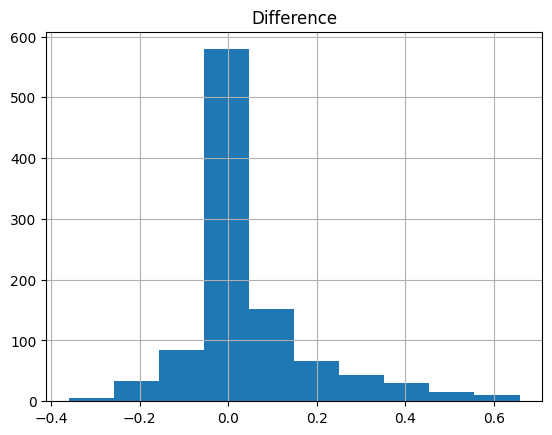

In [ ]:
mlp_difference = compare_model_correct_token_probability("NeelNanda/SoLU_1L512W_C4_Code", "NeelNanda/Attn_Only_1L512W_C4_Code")
mlp_difference.hist(column="Difference", bins=10)

##### By Tokens View

In [ ]:
values = mlp_difference["Difference"].sort_index().values.tolist()
colored_tokens(
    values=values,
    tokens=token_labels,
    min_value=0,
    max_value=1,
    max_color="green",
)

Some high level thoughts of things MLPs may be useful for:

 - General: MLP layers are good at understanding a lot about just one token (after info has potentially been moved there), especially as they typically have 2x the number of parameters as attention layers (and 6x the OV circuit, or 6x * num_tokens). So they should excel in situations where nuanced information must be recalled that is sparse in the training data (e.g. the peculiarities of specific libraries that don't follow common method naming conventions).
 - In practice this broadly seems plausible (but not necessarily correct) from the above data. Specifically:
   - "J" -> "up" (for "Jupyter")
   - "__html__" is a possible method (again only for Jupyter notebooks as it renders HTML if the class is returned)
   - "subprocess" ... -> "c" (for "cwd") as it knows the parameters of `subprocess.call`

It could be interesting when trying to interpret circuits, to try and remove the impact of MLP layers (including removing info moved by attention heads just for the MLP layer to read somehow), so that we know if this is true. Are MLP layers fundamentally narrowing down choices where sparse info is useful?